In [1]:
from utils import *
from models import *


import os
os.chdir('../..')
print(os.getcwd())


/Users/joyqiu/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


using device:  cpu
using device:  cpu
/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns


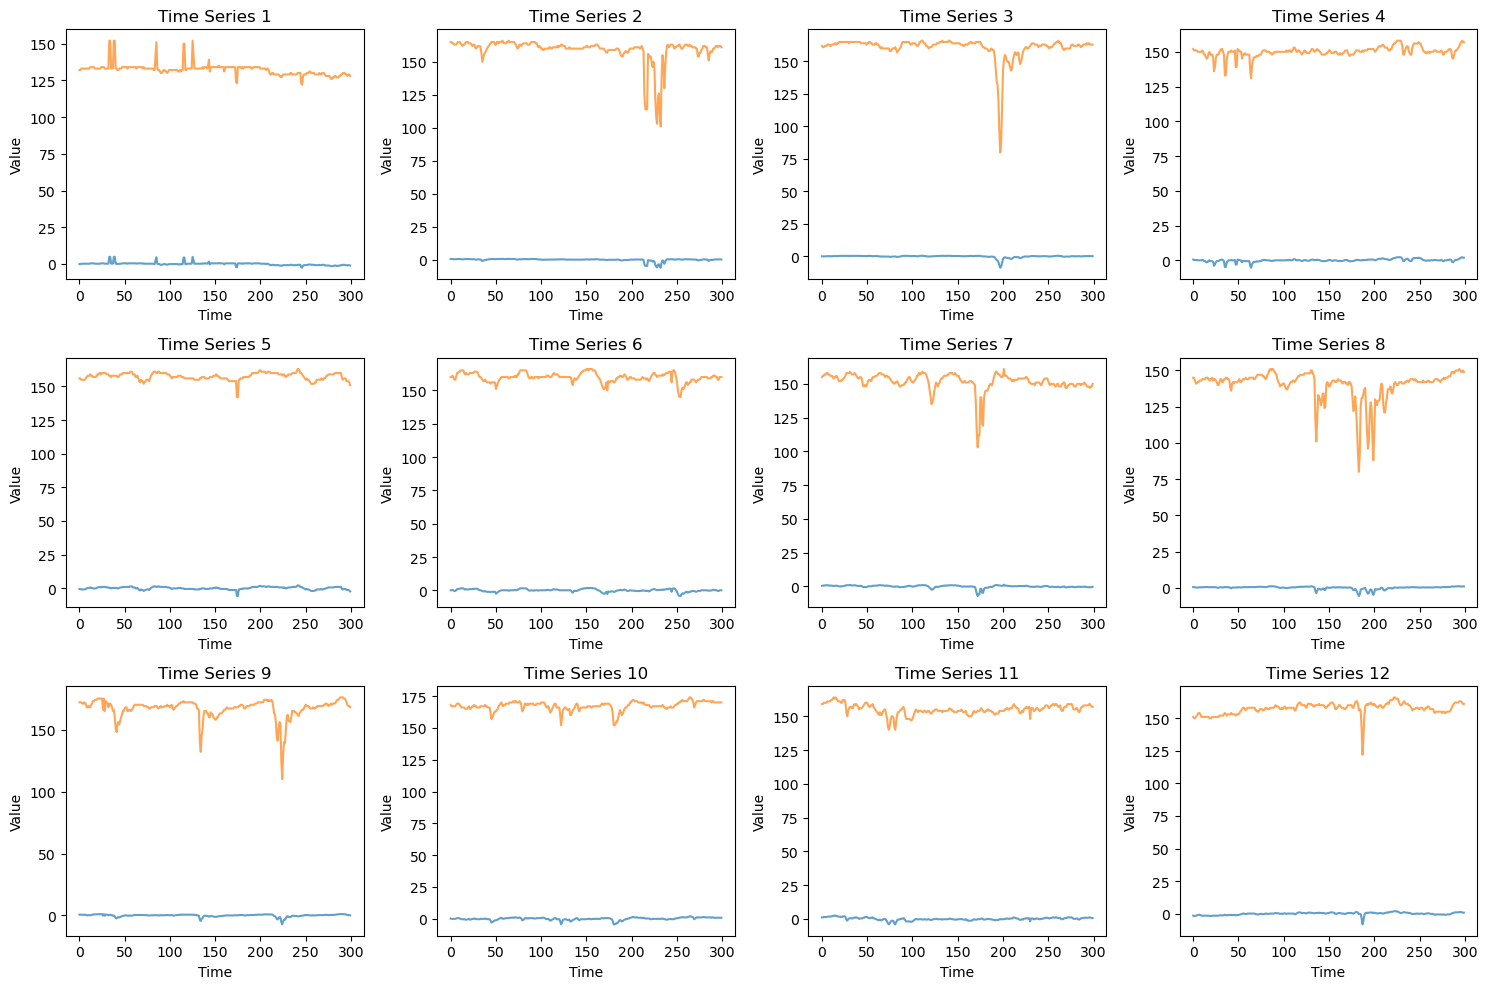

In [2]:
data_path = './data/PAS Challenge HR Data.xlsx'  
batch_size = 128
train_dataloader, test_dataloader, df_scaled, df = prepare_data(data_path, batch_size=batch_size)

In [3]:
overwrite = False
model_path = './script/VAE/results/hr_vae_linear_medium.pth' 
loss_path = './script/VAE/results/hr_train_test_losses_linear_medium.pth'
# Initialize model
model = VAE_Linear_Medium().to(device)
nn_summary(model, 
        input_size=(batch_size, 300),
        col_names=["input_size", "output_size", "num_params", "kernel_size"],
        depth=4)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
VAE_Linear_Medium                        [128, 300]                [128, 300]                --                        --
├─Sequential: 1-1                        [128, 300]                [128, 128]                --                        --
│    └─Linear: 2-1                       [128, 300]                [128, 256]                77,056                    --
│    └─LeakyReLU: 2-2                    [128, 256]                [128, 256]                --                        --
│    └─Linear: 2-3                       [128, 256]                [128, 512]                131,584                   --
│    └─LeakyReLU: 2-4                    [128, 512]                [128, 512]                --                        --
│    └─Linear: 2-5                       [128, 512]                [128, 512]                262,656                   --
│    └─LeakyRe

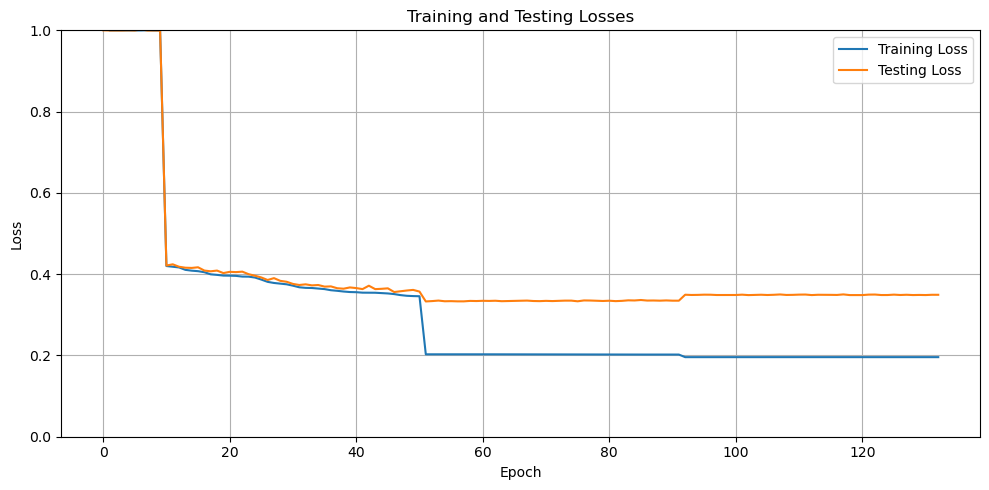

In [4]:

if not os.path.exists(model_path) or overwrite:
    # Train the model
    num_epochs = 10000000000000
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses, test_losses = train(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device
    )
    # Save model locally
    torch.save(model.state_dict(), model_path)
    torch.save((train_losses, test_losses), loss_path)
else:
    # load model from model_path
    model.load_state_dict(torch.load(model_path))
    model.eval()
    train_losses, test_losses = torch.load(loss_path)
    
    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(test_losses, label='Testing Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_ylim(0, 1)
    ax1.set_title('Training and Testing Losses')
    ax1.legend()
    ax1.grid(True)


    plt.tight_layout()
    plt.show()



# wonderful!

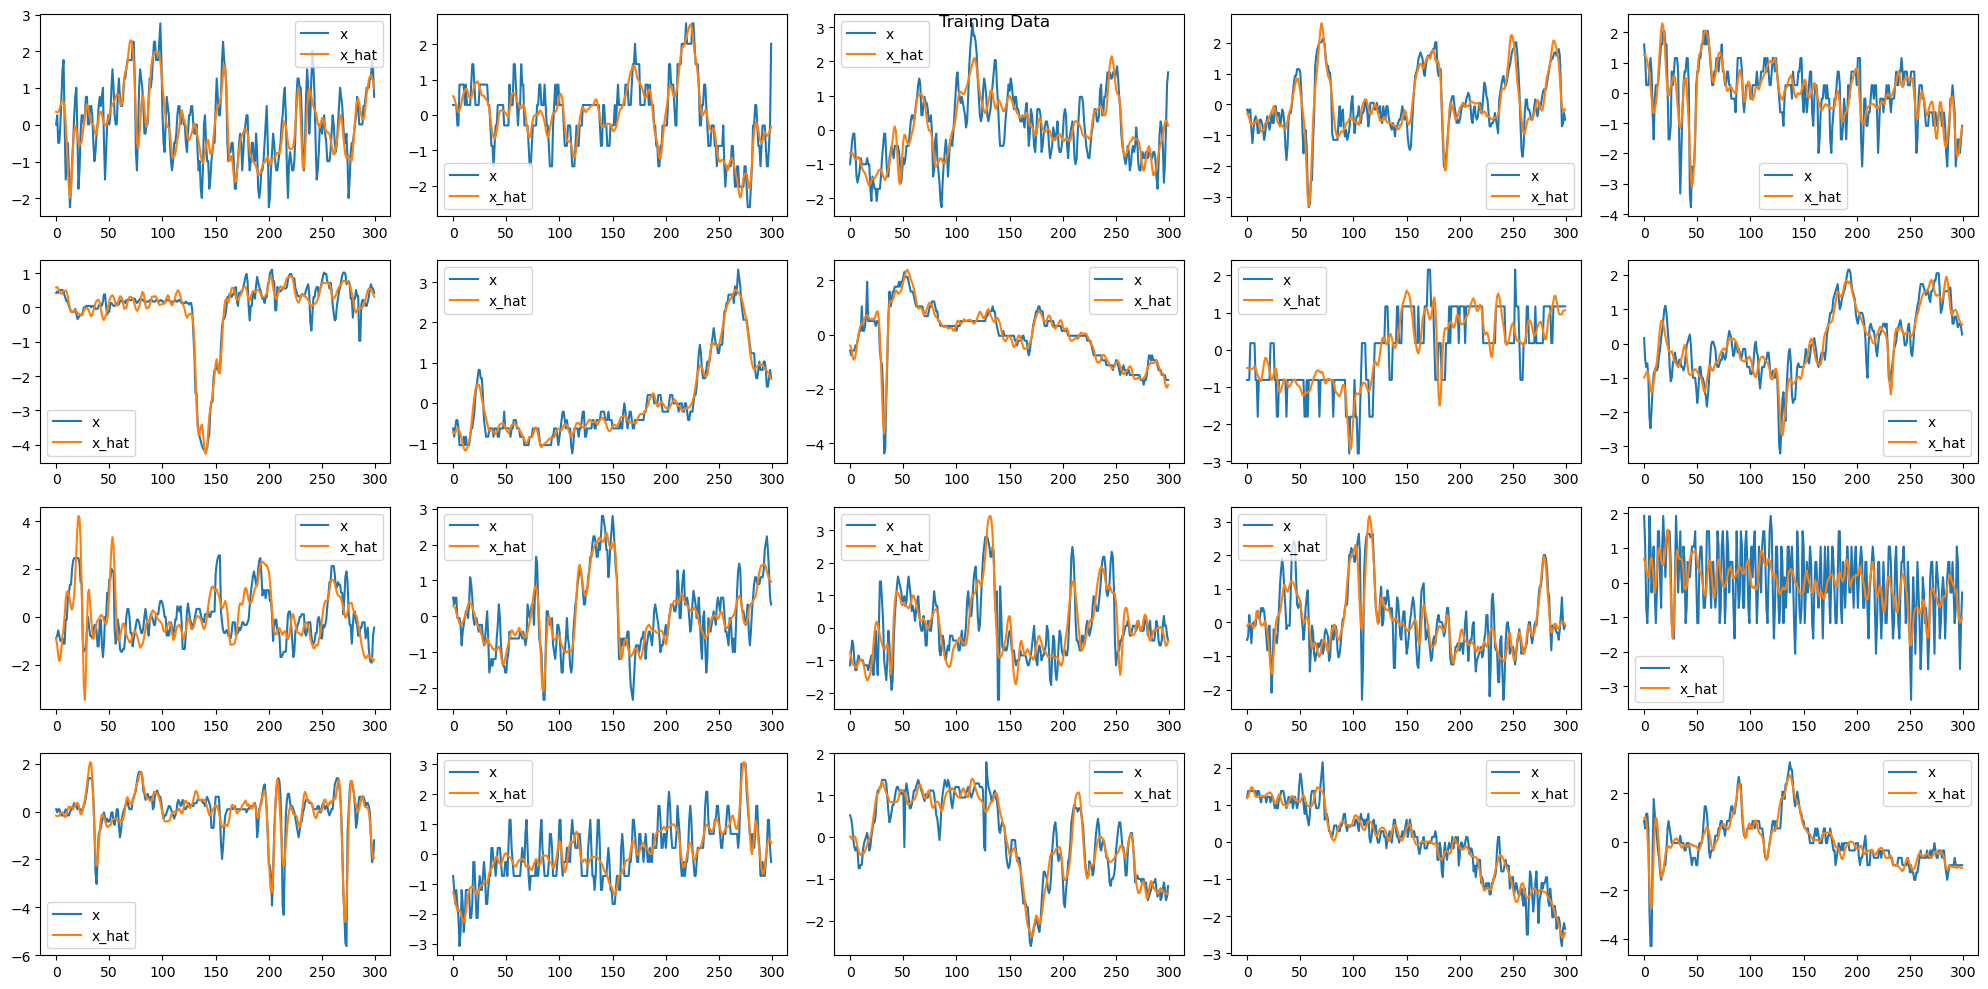

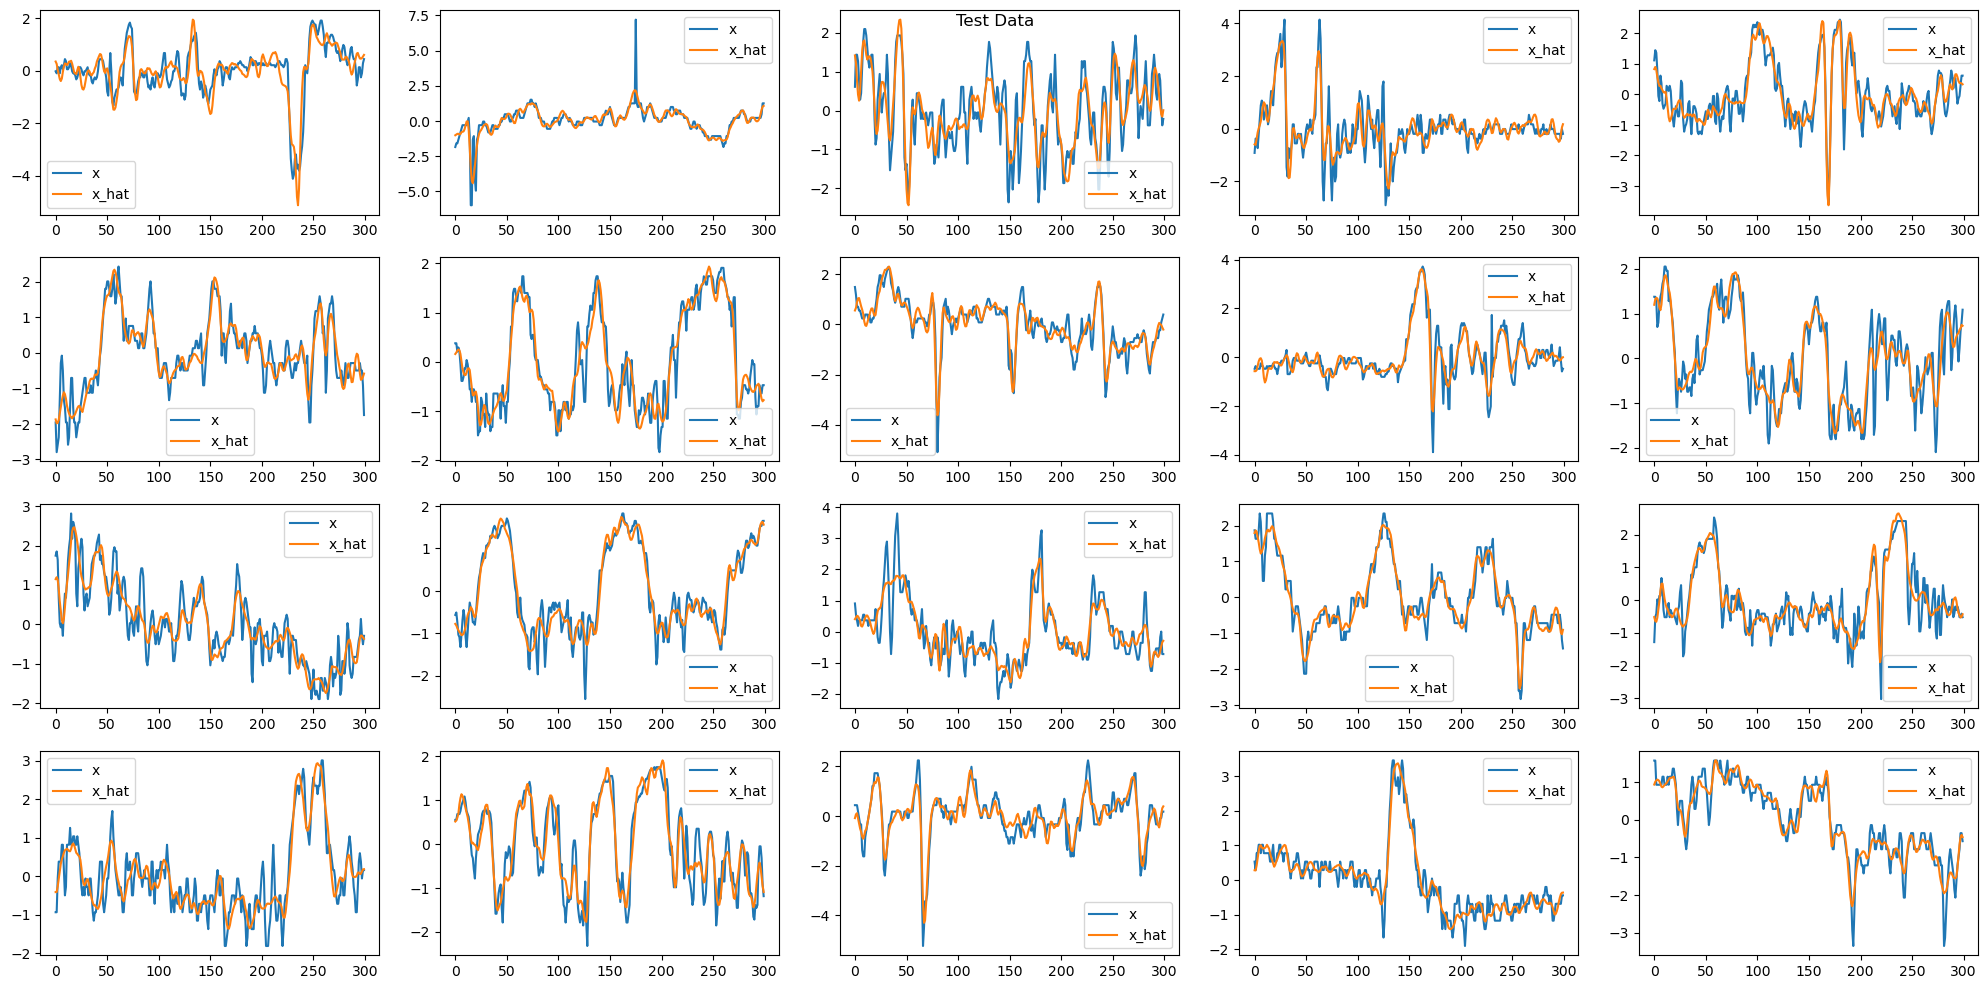

In [5]:
# plot 10 samples of x and x_hat, x_hat is predicted by the model, x is the original data from train_dataloader or test_dataloader

fig, axes = plt.subplots(4, 5, figsize=(20, 10), facecolor='white')
for i in range(20):
    x = train_dataloader.dataset[i]
    x_hat, mean, log_var = model(x)    
    axes[i//5, i%5].plot(x.cpu().numpy(), label='x')
    axes[i//5, i%5].plot(x_hat.cpu().detach().numpy(), label='x_hat')
    axes[i//5, i%5].legend()
plt.tight_layout()
fig.suptitle('Training Data')
plt.show()

fig, axes = plt.subplots(4, 5, figsize=(20, 10), facecolor='white')
for i in range(20):
    x = test_dataloader.dataset[i]
    x_hat, mean, log_var = model(x)    
    axes[i//5, i%5].plot(x.cpu().numpy(), label='x')
    axes[i//5, i%5].plot(x_hat.cpu().detach().numpy(), label='x_hat')
    axes[i//5, i%5].legend()
plt.tight_layout()  
fig.suptitle('Test Data')
plt.show()


## generate new x_hat based on the distance between the embedded space of x and x_hat


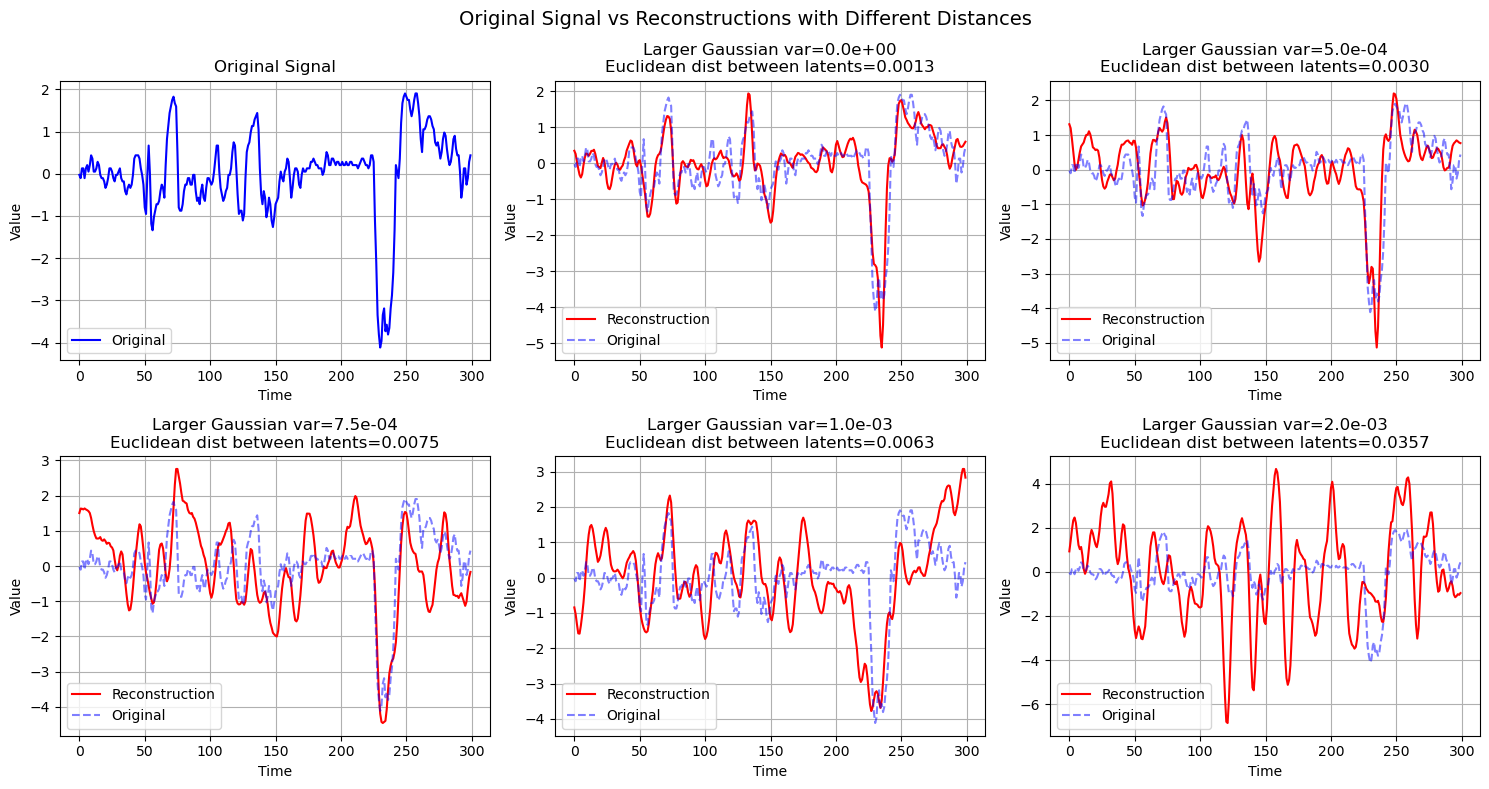

In [6]:
x = test_dataloader.dataset[0]

# Create figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Original Signal vs Reconstructions with Different Distances', fontsize=14)

# Flatten axs for easier iteration
axs = axs.flatten()

# Plot original signal in first subplot
axs[0].plot(x.detach().numpy(), 'b-', label='Original')
axs[0].set_title('Original Signal')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Value')
axs[0].grid(True)
axs[0].legend()

# Plot reconstructions with different distances
distances = [0, 5e-4, 7.5e-4, 1e-3, 2e-3]
for i, distance in enumerate(distances, 1):
    # Get embeddings and reconstruction
    z_mean, z_log_var = model.encode(x)
    z = model.reparameterization(z_mean, z_log_var + distance)
    x_hat = model.decode(z)
    z_mean_hat, z_log_var_hat = model.encode(x_hat)

    # Calculate Euclidean distance
    z_mean = z_mean.cpu().detach().numpy()
    z_mean_hat = z_mean_hat.cpu().detach().numpy()
    euc_dist = np.sqrt(np.sum((z_mean - z_mean_hat) ** 2))

    # Plot reconstruction
    axs[i].plot(x_hat.detach().numpy(), 'r-', label=f'Reconstruction')
    axs[i].plot(x.detach().numpy(), 'b--', alpha=0.5, label='Original')
    axs[i].set_title(f'Larger Gaussian var={distance:.1e}\nEuclidean dist between latents={euc_dist:.4f}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
    axs[i].grid(True)
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()